# Mesure de paramètres météorologiques avec une ministation météo et  affichage dynamique sur un graphique des résultats obtenus

## Langage python, bibliothèques mraa et upm, capteurs TSL2561 MCP9808 BME280
Le but de cette activité est de démontrer l'utilisation d'un nano-ordinateur Raspberry Pi pilotant 3 capteurs (pression, température, hygrométrie, insolation) d'une ministation météorologique. L'outil présenté ici permet d'interagir DIRECTEMENT avec le nano-ordinateur depuis une interface web et d'afficher sur cette interface le diagramme en temps réel des mesures effectuées. Il ne s'agit pas d'une simulation mais d'une situation réelle observée en temps réel.
Les manipulations sont réalisées avec une série de 3 capteurs Adafruit BME280, MCP9808, TSL2561 connectés sue le bus [i2c](https://en.wikipedia.org/wiki/I%C2%B2C) d'une [Raspberry Pi3](https://www.raspberrypi.org/) fonctionnant avec une image Debian Stretch [fournie par l'IFÉ ENS de Lyon](http://mediaserv.climatetmeteo.fr/images/RaspBerry/DebianStretchPi3/), décrite et accompagnée dans ce [blog](http://blog.climatetmeteo.fr/GerardVidal/meteo_jupyter_env.html) disposant des bibliothèques de programmes INTEL [mraa](https://iotdk.intel.com/docs/master/mraa/) et [upm](https://iotdk.intel.com/docs/master/upm/). La bibliothèque [mraa](https://iotdk.intel.com/docs/master/mraa/) fournit tous les programmes permettant l'interaction entre la Raspberry et le matériel de connection des capteurs, la bibliothèque [upm](https://iotdk.intel.com/docs/master/upm/) fournit les pilotes (avec toutes les fonctions d'interaction) de nombreux capteurs du marché.

Ce programme affiche en temps réel dans un graphique la température la pression et l'hygrométrie. Il est composé de 6 blocs qui permettent d'aborder indépendamment chacune des étapes du programme.

### première étape : importations de l'environnement et des bibliothèques
Ce bloc déclare un environnement graphique utilisant `Matplotlib` et faisant appel aux librairies :
 * matplotlib
 * numpy
 * mraa
 * upm
 * math
 * time

In [1]:
%matplotlib notebook

from matplotlib import pyplot as plt
import numpy as np

import mraa, upm, math, time

### Seconde étape :  importation des pilotes des capteurs de la librairie upm

In [92]:
from upm import pyupm_bmp280 as bmp280
from upm import pyupm_tsl2561 as tsl2561
from upm import pyupm_mcp9808 as mcp

### Troisième étape : déclaration des variables et des constantes
On déclare ici le bus utilisé, l'intervalle de mesure, le nom des capteurs utilisés, l'altitude locale et les 6 tableaux qui vont accueillir les mesures. les adresses des capteurs sont facultatives car les déclarations des pilotes incluent la valeur "par défaut", cependantdu fait de la grande variété de capteurs disponibles il se peut que certains capteurs ne soient pas configurés sur l'adresse "par défaut" la déclarer est un élément facilitant le débogage. Il est toujours possible de voir les adresses de capteurs *effectivement* détectées en utilisant dans un terminal la commande `mmraa-i2c detect 0`

In [93]:
bus1 = 0
pauseVal = 0.2
addrbme = 0x77
addrtsl = 0x39
addrmcp = 0x18
bme = bmp280.BME280(bus1,addrbme)
mymcp = mcp.MCP9808(bus1,addrmcp)
mytsl = tsl2561.TSL2561(bus1,addrtsl)

localAlt = 156.5
x = []; mes1 = []; mes2 = [] ; mes3 = []; mes4 = []; mes5 = []; mes6 = []

### Quatrième étape : mise en place de la fonction de réduction de la pression au niveau de la mer
Écriture de la fonction permettant de ramener la pression atmosphérique mesurée au niveau de la mer.

In [94]:
def convertSeaLevel (m_Pressure,m_Temperature,m_alt):
#    s_Pressure = m_Pressure / math.pow(1.0 - localAlt/44330, 5.255)
    s_Pressure = m_Pressure * math.pow((1 - 0.0065 * m_alt / ( m_Temperature + 0.0065 * m_alt + 273.15)), -5.257) 
#    s_Pressure = m_Pressure / math.pow((1 - 0.0065 * m_alt / m_Temperature), 5.255 )
    return s_Pressure

### Quatrième étape : Création de la figure dans laquelle seront affichées les données
Ce bloc met en place une figure avec 4 graphiques : 1 sur la première ligne, 2 sur la seconde 1 sur la troisième. Chacun a un titre un nom pour les axes et une légende. La figure sera affichée sous ce bloc.

<IPython.core.display.Javascript object>


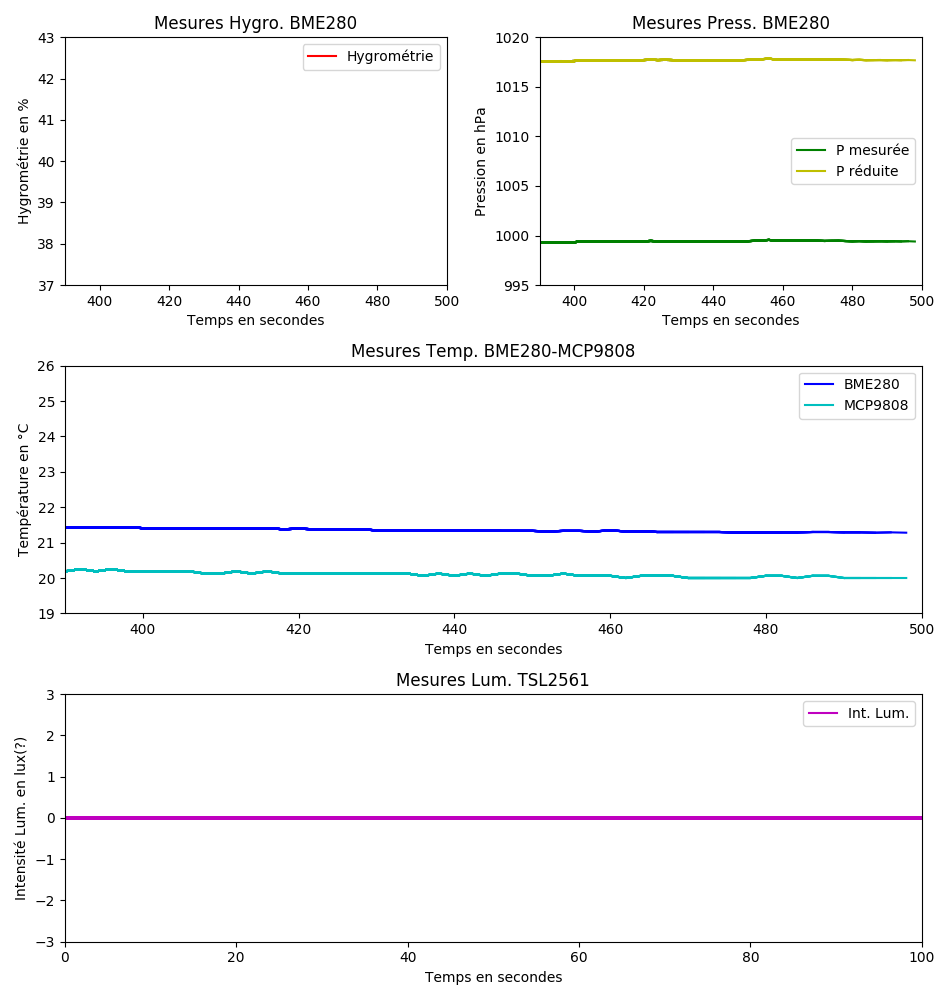

In [95]:
fig = plt.figure(figsize=(9.5,10))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(312)
ax4 = fig.add_subplot(313)

ax1.set_title("Mesures Hygro. BME280")    
ax1.set_xlabel('Temps en secondes')
ax1.set_ylabel('Hygrométrie en %')

ax2.set_title("Mesures Press. BME280")    
ax2.set_xlabel('Temps en secondes')
ax2.set_ylabel('Pression en hPa')

ax3.set_title("Mesures Temp. BME280-MCP9808")    
ax3.set_xlabel('Temps en secondes')
ax3.set_ylabel('Température en °C')

ax4.set_title("Mesures Lum. TSL2561")    
ax4.set_xlabel('Temps en secondes')
ax4.set_ylabel('Intensité Lum. en lux(?)')


ax1.plot(x,mes1, c='r', label='Hygrométrie')
ax2.plot(x,mes2, c='g', label='P mesurée')
ax2.plot(x,mes4, c='y', label='P réduite')
ax3.plot(x,mes3, c='b', label='BME280')
ax3.plot(x,mes5, c='c', label='MCP9808')
ax4.plot(x,mes6, c='m', label='Int. Lum.')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.tight_layout()

### Cinquième étape : recherche rapide de la valeur moyenne et centrage de l'affichage
On effectue 10 mesures pour déterminer la valeur moyenne  de la pression température et hygrométrie qui servent à fixer la hauteur d'affichage.

In [96]:
tbmpmoy = 0.
tmcpmoy =0.
pbmoy = 0.
prmoy = 0.
hmoy = 0.
lmoy = 0.
for i in range(10):
    # bme280 measurements
    bme.update()
    tempBME = bme.getTemperature()
    pressBME = bme.getPressure() / 100.0
    hygroBME = bme.getHumidity()
    pressRed = convertSeaLevel (pressBME,tempBME,localAlt)
    # tsl measurements
    lux = mytsl.getLux()
    # mcp measurements
    tempMCP = mymcp.getTemp()
    time.sleep (pauseVal)
    tbmpmoy += tempBME
    pbmoy += pressBME
    prmoy += pressRed
    hmoy += hygroBME
    lmoy += lux
    tmcpmoy += tempMCP
tbmpmoy /= 10.
pbmoy /= 10.
prmoy /= 10.
hmoy /= 10.
lmoy /= 10.
tmcpmoy /= 10.
tbmpmoy = math.floor(tbmpmoy)
pbmoy = math.floor(pbmoy)
prmoy = math.floor(prmoy)
hmoy = math.floor(hmoy)
lmoy = math.floor(lmoy)
tmcpmoy = math.floor(tmcpmoy)

In [78]:
print("T : {0:.2f};\tP :  {1:.2f};\tPRed : {2:.2f};\tHygro : {3:.2f};\tEcl : {4:.2f};\tThr : {5:.2f};".format(tbmpmoy,pbmoy,prmoy,hmoy,lmoy,tmcpmoy))

T : 23.00;	P :  997.00;	PRed : 1015.00;	Hygro : 40.00;	Ecl : 0.00;	Thr : 22.00;


In [90]:
import mraa, upm
from upm import pyupm_tsl2561 as tsl2561
addrtsl = 0x39
mytsl = tsl2561.TSL2561(bus1,addrtsl,tsl2561.GAIN_16X,tsl2561.INTEGRATION_TIME0_13MS)
# tsl measurements
print(mytsl.getLux())


0


### Sixième étape dessin de la figure
On dessine ici la figure en prenant en compte les paramètres définis dans le bloc précédent

In [97]:
tmin = min([tbmpmoy,tmcpmoy])
tmax = max([tbmpmoy,tmcpmoy])
pmin = min([pbmoy,prmoy])
pmax = max([pbmoy,prmoy])
ax1.set_ylim([(hmoy - 3.0), (hmoy + 3.0)])
ax2.set_ylim([(pmin - 3.0), (pmax + 3.0)])
ax3.set_ylim([(tmin - 3.0),(tmax + 3.0)])
ax4.set_ylim([(lmoy - 3.0), (lmoy + 3.0)])
ax1.set_xlim([0,100])
ax2.set_xlim([0,100])
ax3.set_xlim([0,100])
ax4.set_xlim([0,100])

fig.canvas.draw()

### Sixième étape mesure et tracé  des mesures sur figure en temps réel
le tracé s'effectue dans la figure dessinée ci-dessus.

In [98]:
for jump in range(0,2) :
    lim1 = -10.0 + jump * 100.0
    lim2 = 100.0 + jump * 100.0
    ax1.set_xlim([lim1,lim2])
    ax2.set_xlim([lim1,lim2])
    ax3.set_xlim([lim1,lim2])
    ax4.set_xlim([lim1,lim2])
    plt.tight_layout()
    fig.canvas.draw()
    start = jump * 50
    stop = (jump + 1)*50
    for num in range(start,stop):
        mestime = num * 2.0
        bme.update()
        tempBME = bme.getTemperature()
        pressBME = bme.getPressure() / 100.0
        hygroBME = bme.getHumidity()
        pressRed = convertSeaLevel (pressBME,tempBME,localAlt)
        # tsl measurements
        lux = mytsl.getLux()
        # mcp measurements
        tempMCP = mymcp.getTemp()
        time.sleep (pauseVal)
   
        x.append(float(mestime))
        mes1.append(float(hygroBME))
        mes2.append(float(pressBME))
        mes3.append(float(tempBME))
        mes4.append(float(pressRed))
        mes5.append(float(tempMCP))
        mes6.append(float(lux))
        ax1.plot(x,mes1, c='r', label='Hygrométrie')
        ax2.plot(x,mes2, c='g', label='P mesurée')
        ax2.plot(x,mes4, c='y', label='P réduite')
        ax3.plot(x,mes3, c='b', label='BME280')
        ax3.plot(x,mes5, c='c', label='MCP9808')
        ax4.plot(x,mes6, c='m', label='Int. Lum.')
        fig.canvas.draw()

### Code complet par fusion des blocs

Le bloc ci-dessous regroupe l'ensemble des blocs fragmentés et expliqués ci-dessus en une seule entité permettant d'exécuter la totalité du programme.

<IPython.core.display.Javascript object>


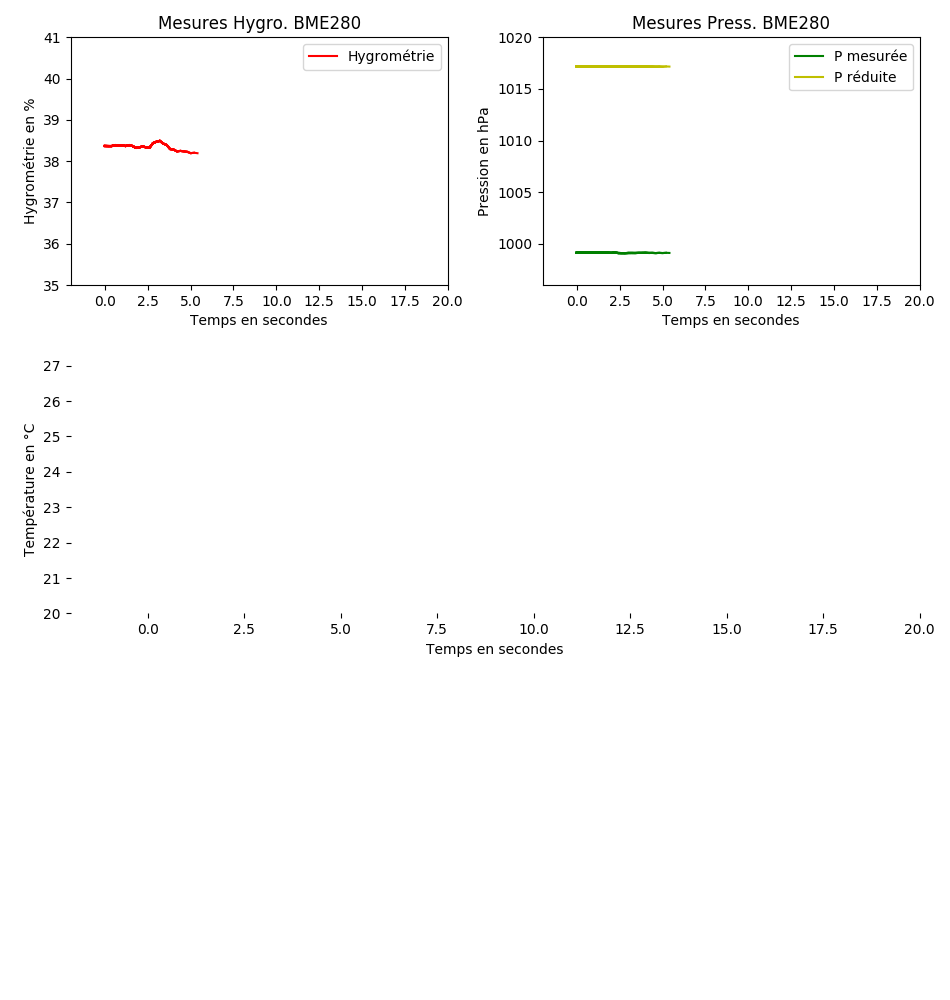

KeyboardInterrupt: 

In [1]:
%matplotlib notebook

from matplotlib import pyplot as plt
import numpy as np

import mraa, upm, math, time

from upm import pyupm_bmp280 as bmp280
from upm import pyupm_tsl2561 as tsl2561
from upm import pyupm_mcp9808 as mcp

bus1 = 0
pauseVal = 0.2
addrbme = 0x77
addrtsl = 0x39
addrmcp = 0x18
bme = bmp280.BME280(bus1,addrbme)
mymcp = mcp.MCP9808(bus1,addrmcp)
mytsl = tsl2561.TSL2561(bus1,addrtsl)
localAlt = 156.5
x = []; mes1 = []; mes2 = [] ; mes3 = []; mes4 = []; mes5 = []; mes6 = []

def convertSeaLevel (m_Pressure,m_Temperature,m_alt):
#    s_Pressure = m_Pressure / math.pow(1.0 - localAlt/44330, 5.255)
    s_Pressure = m_Pressure * math.pow((1 - 0.0065 * m_alt / ( m_Temperature + 0.0065 * m_alt + 273.15)), -5.257) 
#    s_Pressure = m_Pressure / math.pow((1 - 0.0065 * m_alt / m_Temperature), 5.255 )
    return s_Pressure

fig = plt.figure(figsize=(9.5,10))

ax1 = fig.add_subplot(321)
ax2 = fig.add_subplot(322)
ax3 = fig.add_subplot(312)
ax4 = fig.add_subplot(313)

ax1.set_title("Mesures Hygro. BME280")    
ax1.set_xlabel('Temps en secondes')
ax1.set_ylabel('Hygrométrie en %')

ax2.set_title("Mesures Press. BME280")    
ax2.set_xlabel('Temps en secondes')
ax2.set_ylabel('Pression en hPa')

ax3.set_title("Mesures Temp. BME280-MCP9808")    
ax3.set_xlabel('Temps en secondes')
ax3.set_ylabel('Température en °C')

ax4.set_title("Mesures Lum. TSL2561")    
ax4.set_xlabel('Temps en secondes')
ax4.set_ylabel('Intensité Lum. en lux(?)')


ax1.plot(x,mes1, c='r', label='Hygrométrie')
ax2.plot(x,mes2, c='g', label='P mesurée')
ax2.plot(x,mes4, c='y', label='P réduite')
ax3.plot(x,mes3, c='b', label='BME280')
ax3.plot(x,mes5, c='c', label='MCP9808')
ax4.plot(x,mes6, c='m', label='Int. Lum.')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()
plt.tight_layout()

tbmpmoy = 0.
tmcpmoy =0.
pbmoy = 0.
prmoy = 0.
hmoy = 0.
lmoy = 0.
for i in range(10):
    # bme280 measurements
    bme.update()
    tempBME = bme.getTemperature()
    pressBME = bme.getPressure() / 100.0
    hygroBME = bme.getHumidity()
    pressRed = convertSeaLevel (pressBME,tempBME,localAlt)
    # tsl measurements
    lux = mytsl.getLux()
    # mcp measurements
    tempMCP = mymcp.getTemp()
    time.sleep (pauseVal)
    tbmpmoy += tempBME
    pbmoy += pressBME
    prmoy += pressRed
    hmoy += hygroBME
    lmoy += lux
    tmcpmoy += tempMCP
    
tbmpmoy /= 10.
pbmoy /= 10.
prmoy /= 10.
hmoy /= 10.
lmoy /= 10.
tmcpmoy /= 10.
tbmpmoy = math.floor(tbmpmoy)
pbmoy = math.floor(pbmoy)
prmoy = math.floor(prmoy)
hmoy = math.floor(hmoy)
lmoy = math.floor(lmoy)
tmcpmoy = math.floor(tmcpmoy)

tmin = min([tbmpmoy,tmcpmoy])
tmax = max([tbmpmoy,tmcpmoy])
pmin = min([pbmoy,prmoy])
pmax = max([pbmoy,prmoy])
ax1.set_ylim([(hmoy - 3.0), (hmoy + 3.0)])
ax2.set_ylim([(pmin - 3.0), (pmax + 3.0)])
ax3.set_ylim([(tmin - 3.0),(tmax + 3.0)])
ax4.set_ylim([(lmoy - 100.0), (lmoy + 100.0)])
ax1.set_xlim([0,100])
ax2.set_xlim([0,100])
ax3.set_xlim([0,100])
ax4.set_xlim([0,100])

fig.canvas.draw()

for jump in range(0,2) :
    lim1 = (-10.0 + jump * 100.0) * pauseVal
    lim2 = (100.0 + jump * 100.0) * pauseVal
    ax1.set_xlim([lim1,lim2])
    ax2.set_xlim([lim1,lim2])
    ax3.set_xlim([lim1,lim2])
    ax4.set_xlim([lim1,lim2])
    plt.tight_layout()
    fig.canvas.draw()
    start = jump * 100 
    stop = (jump + 1) * 100
    for num in range(start,stop):
        mestime = num * pauseVal
        bme.update()
        tempBME = bme.getTemperature()
        pressBME = bme.getPressure() / 100.0
        hygroBME = bme.getHumidity()
        pressRed = convertSeaLevel (pressBME,tempBME,localAlt)
        # tsl measurements
        lux = mytsl.getLux()
        # mcp measurements
        tempMCP = mymcp.getTemp()
#        time.sleep (pauseVal)
   
        x.append(float(mestime))
        mes1.append(float(hygroBME))
        mes2.append(float(pressBME))
        mes3.append(float(tempBME))
        mes4.append(float(pressRed))
        mes5.append(float(tempMCP))
        mes6.append(float(lux))
        ax1.plot(x,mes1, c='r', label='Hygrométrie')
        ax2.plot(x,mes2, c='g', label='P mesurée')
        ax2.plot(x,mes4, c='y', label='P réduite')
        ax3.plot(x,mes3, c='b', label='BME280')
        ax3.plot(x,mes5, c='c', label='MCP9808')
        ax4.plot(x,mes6, c='m', label='Int. Lum.')
        fig.canvas.draw()